In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
import shap

import matplotlib.pyplot as plt

# Outbreak prediction using Random Forest Experiment

Steps:
1. Split data by timestamp into training and testing set
2. Run RF model
3. Perform SHAP to get feature importance

Possible iterations: removing the static values, removing the annual values, removing both.

RandomForest in sklearn does not handle nulls, would need to remove the nulls. **In this run, the preprocessing includes:**
- Removing rows that did not contain Age statistics (Age_mean, Age_median, etc.) --- this essentially dropped the added time series rows that had no health data to them at all
- Dropped Ookla columns for now since they only match 2 years with the dataset
- RWI also removed and too many nulls --- also expected that the values would be repetitive since it is too coarse (bring back this feature if done at city level)
- population density columns are also removed for now since they contain plenty of nulls --- apparently it looks like if there are population count values in the raster, does not mean there are population density values too?

Try for next iteration:
- remove other feature
- city-level linked data?

In [2]:
PROCESSED_DIR = Path("../../data/03-processed/")
LINKED_DATA = PROCESSED_DIR / "filtered_linked_df.csv"

## Load dataset

In [3]:
# try filtering to check how much we have
filtered_linked_df = pd.read_csv(LINKED_DATA)
filtered_linked_df.head()

,date,ADM4_PCODE,NumCases,Female,Male,outbreak,CO_AVG,CO_MIN,CO_MAX,CO_STD,...,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
0,2014-01-27,PH097332001,1.0,1.0,0.0,0,0.074671,0.0711,0.082,0.004529,...,0.00,0.00,3611.67,76.28,0.00,0.00,0.0,0.0,0.0,0.0
1,2014-01-27,PH097332002,2.0,1.0,1.0,0,0.074671,0.0711,0.082,0.004529,...,0.00,0.00,9497.76,64.74,10518.68,71.70,0.0,0.0,0.0,0.0
2,2014-01-27,PH097332004,4.0,3.0,1.0,0,0.074671,0.0711,0.082,0.004529,...,5930.91,23.38,25016.24,98.61,23340.23,92.01,0.0,0.0,0.0,0.0
3,2014-01-27,PH097332005,0.0,NaN,NaN,0,0.074671,0.0711,0.082,0.004529,...,0.00,0.00,838.27,11.97,0.00,0.00,0.0,0.0,0.0,0.0
4,2014-01-27,PH097332010,0.0,NaN,NaN,0,0.074671,0.0711,0.082,0.004529,...,358.76,5.64,2953.82,46.47,0.00,0.00,0.0,0.0,0.0,0.0


In [4]:
filtered_linked_df["date"] = pd.to_datetime(filtered_linked_df["date"])
filtered_linked_df = filtered_linked_df.sort_values(by=["date"])
filtered_linked_df.head()

,date,ADM4_PCODE,NumCases,Female,Male,outbreak,CO_AVG,CO_MIN,CO_MAX,CO_STD,...,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
0,2014-01-27,PH097332001,1.0,1.0,0.0,0,0.074671,0.0711,0.082,0.004529,...,0.00,0.00,3611.67,76.28,0.00,0.00,0.0,0.0,0.0,0.0
69,2014-01-27,PH097332077,1.0,1.0,0.0,0,0.074671,0.0711,0.082,0.004529,...,4859.95,102.01,4859.95,102.01,4348.94,91.28,0.0,0.0,0.0,0.0
68,2014-01-27,PH097332076,2.0,1.0,1.0,0,0.074671,0.0711,0.082,0.004529,...,11814.54,34.21,6192.50,17.93,9878.40,28.60,0.0,0.0,0.0,0.0
67,2014-01-27,PH097332075,4.0,1.0,3.0,1,0.074671,0.0711,0.082,0.004529,...,6583.66,88.94,7287.22,98.45,7339.76,99.16,0.0,0.0,0.0,0.0
66,2014-01-27,PH097332074,1.0,1.0,0.0,0,0.074671,0.0711,0.082,0.004529,...,3710.70,82.11,3997.88,88.47,3997.88,88.47,0.0,0.0,0.0,0.0


Select one baranggay

In [5]:
filtered_linked_df = filtered_linked_df[filtered_linked_df['ADM4_PCODE']=='PH097332087']
#all_dates = pd.date_range(start=filtered_linked_df.index.min(), end=filtered_linked_df.index.max(), freq='W-MON')
filtered_linked_df  = filtered_linked_df.set_index(['date', 'ADM4_PCODE'])\
            .unstack(fill_value=0)\
            .asfreq('W-MON', fill_value=0)\
            .stack().sort_index(level=1).reset_index()
filtered_linked_df.head()

,date,ADM4_PCODE,NumCases,Female,Male,outbreak,CO_AVG,CO_MIN,CO_MAX,CO_STD,...,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,prev_1_wk_numcases,prev_2_wk_numcases,prev_3_wk_numcases,prev_1_mo_numcases
0,2014-01-27,PH097332087,4.0,2.0,2.0,0,0.074671,0.0711,0.0820,0.004529,...,17253.49,63.46,2831.49,10.41,24367.76,89.62,0.0,0.0,0.0,0.0
1,2014-02-03,PH097332087,0.0,0.0,0.0,0,0.000000,0.0000,0.0000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
2,2014-02-10,PH097332087,0.0,0.0,0.0,0,0.000000,0.0000,0.0000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
3,2014-02-17,PH097332087,0.0,0.0,0.0,0,0.000000,0.0000,0.0000,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,2014-02-24,PH097332087,6.0,5.0,1.0,1,0.078400,0.0717,0.0874,0.005491,...,17253.49,63.46,2831.49,10.41,24367.76,89.62,4.0,0.0,0.0,0.0


## Split training and testing

In [6]:
# split features and target label
X = filtered_linked_df.drop(labels=["outbreak"], axis=1)
y = filtered_linked_df["outbreak"]

In [7]:
tss = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
len(X_train), len(X_test)

(43, 8)

## Run RF Regressor

In [ ]:
regressor = RandomForestRegressor(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth' : [None, 5, 10, 15, 20]
}

In [ ]:
model_grid_search = GridSearchCV(regressor, param_grid, verbose = 1, cv = cv)
model_grid_search.fit(X_train, y_train)

In [ ]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.4}")
print(f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.4}")

In [ ]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

In [ ]:
# Evaluate the model on test data
best_rf_regressor_model = model_grid_search.best_estimator_
test_accuracy = best_rf_regressor_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

### Check Results

In [17]:
# Make predictions on the test set
y_pred =  best_rf_regressor_model.predict(X_test)
pred_results = pd.DataFrame(y_pred)
pred_results.describe()

In [21]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(
    f"""
    R2-score: {r2} \n
    MAE: {mae} \n
    MSE: {mse} \n
    RMSE: {rmse} \n
"""
)


    R2-score: 0.5076571378593273 

    MAE: 0.15596445929526123 

    MSE: 0.12070329207168894 

    RMSE: 0.34742379318591426 




In [ ]:
classification_report(y_test,y_pred)

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_rf_regressor_model.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=best_rf_regressor_model.classes_
)
disp.plot()
plt.show()

Check feature importance

In [22]:
sample = X_test.sample(n=2500, random_state=1)
sample

,year,NumCases,Age_min,Age_max,Age_mean,Age_median,Age_std,Female,Male,CO_AVG,...,google_bldgs_density,google_bldgs_pct_built_up_area,travel_time,hospital_pop_reached_total,hospital_pop_reached_pct,healthcenter_pop_reached_total,healthcenter_pop_reached_pct,rhu_pop_reached_total,rhu_pop_reached_pct,revised_pcode
start_of_week,,,,,,,,,,,,,,,,,,,,,
2019-09-30,2019,3.0,1.973990,6.581793,4.914442,6.187543,2.554124,1.0,2.0,0.053829,...,0.006599,54.976935,15,0.00,0.00,0.00,0.00,0.00,0.00,97332020
2019-07-29,2019,2.0,1.700205,13.420944,7.560575,7.560575,8.287814,1.0,1.0,0.057400,...,0.001622,7.491233,24,628.65,9.44,0.00,0.00,0.00,0.00,97332086
2019-07-29,2019,4.0,3.036277,28.147844,13.526352,11.460644,10.526996,1.0,3.0,0.057400,...,0.001290,7.390577,23,2235.60,7.75,4.97,0.02,86.88,0.30,97332048
2019-07-29,2019,2.0,12.851472,19.036276,15.943874,15.943874,4.373317,0.0,2.0,0.056771,...,0.000059,0.358962,5,0.00,0.00,776.75,22.14,0.00,0.00,97332034
2020-01-27,2020,2.0,3.000000,17.000000,10.000000,10.000000,9.899495,2.0,0.0,0.082800,...,0.003791,36.095131,14,55.34,1.00,0.00,0.00,30.14,0.54,97332021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,2019,5.0,8.925393,64.262833,28.230527,20.268309,22.249256,3.0,2.0,0.055143,...,0.000761,4.904170,7,579.45,11.55,236.67,4.72,774.77,15.44,97332023
2019-10-28,2019,3.0,3.846680,13.319644,7.698836,5.930185,4.977987,2.0,1.0,0.059843,...,0.003284,27.311919,19,0.00,0.00,0.00,0.00,0.00,0.00,97332031
2019-07-29,2019,6.0,2.581793,43.994526,15.843487,12.275154,14.645139,3.0,3.0,0.057400,...,0.003791,36.095131,29,0.00,0.00,0.00,0.00,0.00,0.00,97332021


In [23]:
explainer = shap.Explainer(regressor)
shap_values = explainer.shap_values(sample)

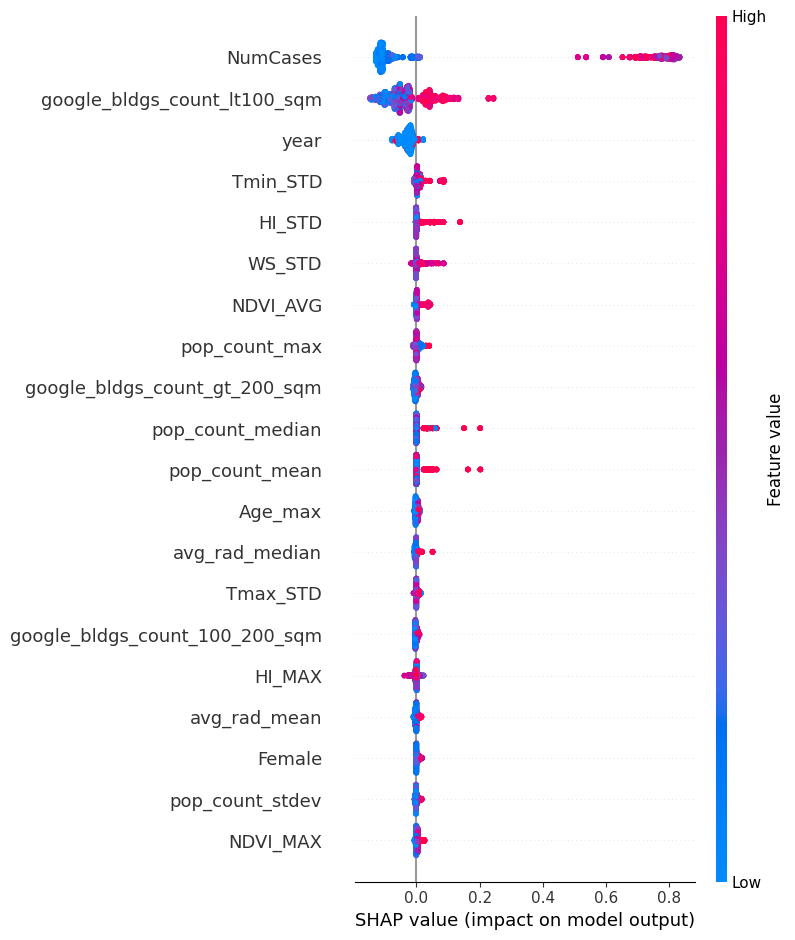

In [24]:
shap.summary_plot(shap_values, sample)

## RF Classifier

In [ ]:
classifier = RandomForestClassifier(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth' : [None, 5, 10, 15, 20]
}

In [ ]:
model_grid_search = GridSearchCV(classifier, param_grid, verbose = 1, cv = cv)
model_grid_search.fit(X_train, y_train)

In [ ]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.4}")
print(f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.4}")

In [ ]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

In [ ]:
# Evaluate the model on test data
best_rf_classifier_model = model_grid_search.best_estimator_
test_accuracy = best_rf_classifier_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

### Check Results

In [ ]:
# Make predictions on the test set
y_pred =  best_rf_classifier_model.predict(X_test)
y_pred_proba = best_rf_classifier_mode.predict_proba(X_test)
pred_results = pd.DataFrame(y_pred)
pred_results.describe()

In [ ]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(
    f"""
    R2-score: {r2} \n
    MAE: {mae} \n
    MSE: {mse} \n
    RMSE: {rmse} \n
"""
)


    R2-score: 0.5076571378593273 

    MAE: 0.15596445929526123 

    MSE: 0.12070329207168894 

    RMSE: 0.34742379318591426 




In [ ]:
classification_report(y_test,y_pred)

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_rf_classifier_model.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=best_rf_classifier_model.classes_
)
disp.plot()
plt.show()

In [ ]:
# prediction = y_pred_proba[:, 1]  # prediction for outbreak
# plt.figure(figsize=(15, 7))
# plt.hist(prediction[y_test == 0], bins=50, label="No Outbreak")
# plt.hist(prediction[y_test == 1], bins=50, label="Outbreak", alpha=0.7, color="r")
# plt.xlabel("Probability of being Outbreak Class", fontsize=10)
# plt.ylabel("Number of records in each bucket", fontsize=10)
# plt.legend(fontsize=15, title="Actual Labels")
# plt.tick_params(axis="both", labelsize=8, pad=5)
# plt.show()

Check feature importance

In [32]:
sample = X_test.sample(n=2500, random_state=1)
explainer = shap.Explainer(clf_regressor)
shap_values = explainer.shap_values(sample)

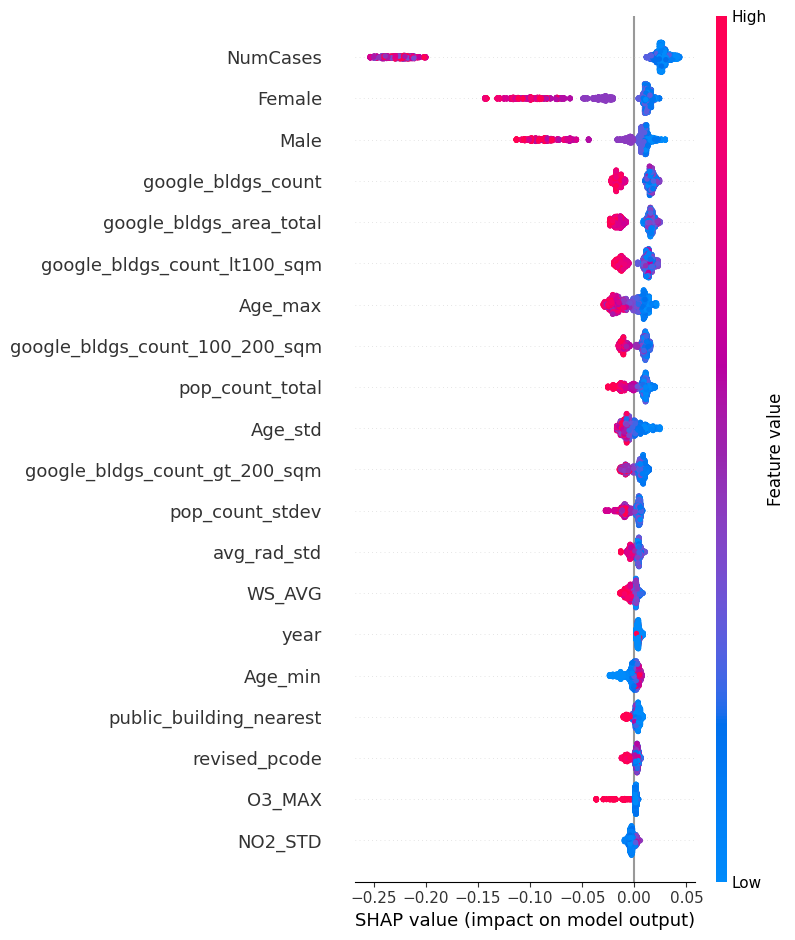

In [33]:
shap.summary_plot(shap_values[0], sample)

## Select model to use

Add code to produce "test_dataset_for_analysis.csv" from `05-run-model-classifier.ipynb`